![](https://www.gstatic.com/devrel-devsite/v2355ed73ae6b243a36832e70498f2cd0b3f352ff30481ebdfdc56826b566bf8a/tensorflow/images/lockup.svg)

До сегодняшнего дня мы собирали различные довольно простые модели в высокоуровневом API для [tensorflow](https://www.tensorflow.org/) под названием Keras. Сегодня, наконец, пришло время поиграться с голым ~~королём~~ функционалом библиотеки и посмотреть, как в нём собираются и обучаются самые простые модели. 

In [ ]:
!pip3 install tensorflow

In [8]:
import numpy as np

In [2]:
import tensorflow as tf
tf.__version__  # ОУУУУ ЩИИИИТ, ВТОРАЯ ВЕРСИЯ!!! АААААААААААА

'2.0.0'

# 0. Tensoflow teaser

Давайте реализуем на `numpy` и на `tensorflow` функцию для поиска суммы квадратов первых $N$ чисел и посмотрим насколько быстро эти функции работают.

In [3]:
np.arange(5)**2

array([ 0,  1,  4,  9, 16])

In [4]:
def np_sum_squares(N):
    return np.sum(np.arange(N)**2)

In [5]:
%%timeit
N = 10**8
np_sum_squares(N)

1.38 s ± 47.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Тут был пример с релокацией. 

In [9]:
%%timeit
a = [ ]
for i in range(10**6):
    a.append(i)

139 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit
a = [0]*10**6
for i in range(10**6):
    a[i] = i

89.6 ms ± 2.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Tensorflow из-за того, что мы сначала задаём структуру вычислений, а после осуществляем их, работает быстрее.

In [6]:
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [7]:
%%timeit
N = 10**8
tf_sum_squares(N)

882 ms ± 35.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Более того, когда вы уже задали свой граф вычислений и убедились, что всё работает, можно вызвать декоратор `tf.function`. [Он сделает работу заданного графа](https://www.tensorflow.org/tutorials/customization/performance) более оптимальной и ещё сильнее ускорит код. 

In [11]:
@tf.function
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [12]:
%%timeit
N = 10**8
tf_sum_squares(N)

247 µs ± 41.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Если сравнивать время, то мы видим значительный прогресс в скорости вычислений даже для простой задачи. Данный прирост будет значительно большим для сложных и тяжелых по памяти рассчетов.

# 1. Тензоры и базовые операции над ними

Основной объект в tensorflow - это **тензор.** Или многомерный массив чисел. Чтобы не нужно было учить кучу новых команд, tensorflow косплеит numpy. 

```
    np.zeros -> tf.zeros
    np.sin -> tf.sin
    np.mean -> tf.reduce_mean
    np.arange -> tf.range
    np.cumsum -> tf.cumsum
```

Правда говоря, не совсем косплеит. Но чаще всего оказываетс довольно близок.

In [20]:
# можно задать тензор из нулей
tf.zeros([3, 4])

<tf.Tensor: id=126, shape=(3, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [21]:
# или из единиц, но уже более сложной размерности
tf.ones([3, 4, 2])

<tf.Tensor: id=129, shape=(3, 4, 2), dtype=float32, numpy=
array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]], dtype=float32)>

In [22]:
# можно сгенерировать тензор из нормального распределения
tf.random.normal([2,2])

<tf.Tensor: id=135, shape=(2, 2), dtype=float32, numpy=
array([[-0.5758274 , -0.57165456],
       [-1.2391686 ,  0.2264114 ]], dtype=float32)>

In [23]:
# можно просто сделать залифку тензора какими-то числами
tf.fill([2, 2], 0.5)

<tf.Tensor: id=138, shape=(2, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

In [24]:
# можно создать матрицу в numpy
x = np.array([[1, 2, 3, 4],
              [4, 3, 2, 1]])
x

array([[1, 2, 3, 4],
       [4, 3, 2, 1]])

In [25]:
# а потом перевести её в тензор
tf.convert_to_tensor(x, tf.float32) 

<tf.Tensor: id=139, shape=(2, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [4., 3., 2., 1.]], dtype=float32)>

In [26]:
# или можно просто сразу создать тензор 
tf.constant([[1,  2,  3,  4],
             [5,  6,  7,  8],
             [9, 10, 11, 12]])

<tf.Tensor: id=140, shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]], dtype=int32)>

In [27]:
# наверное, стоит уточнить тип данных в тензоре
x = tf.constant([[1,  2,  3,  4],
                 [5,  6,  7,  8],
                 [9, 10, 11, 12]], dtype=tf.float32)

Все срезы, операции, размерности работают как в numpy.

In [28]:
x.dtype

tf.float32

In [29]:
x.shape

TensorShape([3, 4])

In [32]:
x[0]

<tf.Tensor: id=145, shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

In [33]:
x[:,1]

<tf.Tensor: id=149, shape=(3,), dtype=float32, numpy=array([ 2.,  6., 10.], dtype=float32)>

In [34]:
x + 10

<tf.Tensor: id=151, shape=(3, 4), dtype=float32, numpy=
array([[11., 12., 13., 14.],
       [15., 16., 17., 18.],
       [19., 20., 21., 22.]], dtype=float32)>

In [35]:
x[x > 3]

<tf.Tensor: id=180, shape=(9,), dtype=float32, numpy=array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.], dtype=float32)>

In [36]:
y = tf.constant([[12, 11, 10, 9],
                  [8, 7, 6, 5],
                  [4, 3, 2, 1]], dtype=tf.float32)

In [37]:
x + y

<tf.Tensor: id=182, shape=(3, 4), dtype=float32, numpy=
array([[13., 13., 13., 13.],
       [13., 13., 13., 13.],
       [13., 13., 13., 13.]], dtype=float32)>

In [38]:
x**y

<tf.Tensor: id=183, shape=(3, 4), dtype=float32, numpy=
array([[1.00000e+00, 2.04800e+03, 5.90490e+04, 2.62144e+05],
       [3.90625e+05, 2.79936e+05, 1.17649e+05, 3.27680e+04],
       [6.56100e+03, 1.00000e+03, 1.21000e+02, 1.20000e+01]],
      dtype=float32)>

In [42]:
tf.math.exp(x)

<tf.Tensor: id=186, shape=(3, 4), dtype=float32, numpy=
array([[2.7182817e+00, 7.3890562e+00, 2.0085537e+01, 5.4598152e+01],
       [1.4841316e+02, 4.0342880e+02, 1.0966332e+03, 2.9809580e+03],
       [8.1030840e+03, 2.2026465e+04, 5.9874141e+04, 1.6275480e+05]],
      dtype=float32)>

In [40]:
# Когда надоело работать с тензором, можно вернуться назад в numpy формат
x.numpy() 

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)

In [41]:
# тип у тензоров может быть разный, но всегда один
tf.constant("hello world")

<tf.Tensor: id=185, shape=(), dtype=string, numpy=b'hello world'>

### Задание 1:

Попробуйте реализовать на tensorflow сигмоиду. 

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [44]:
x = tf.linspace(-1., 1., 10)

def sigmoida(x):
    return 1/(1 + tf.exp(-x))

sigmoida(x)

<tf.Tensor: id=200, shape=(10,), dtype=float32, numpy=
array([0.26894143, 0.314799  , 0.36457646, 0.41742983, 0.4722508 ,
       0.52774924, 0.5825702 , 0.6354236 , 0.685201  , 0.7310586 ],
      dtype=float32)>

### Задание 2:

Попробуйте реализовать на tensorflow среднюю квадратичную ошибку. 

$$ 
MSE(\hat y, y) = \sum_{i=1}^n (\hat y - y)^2
$$

In [45]:
y_true = tf.constant([1, 2, 3, 4, 5])
y_pred = tf.constant([5, 4, 3, 1, 8])

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.pow((y_true - y_pred), 2))

mse(y_true, y_pred)

<tf.Tensor: id=207, shape=(), dtype=int32, numpy=7>

------------------------------------------

# 2. Производные да градиенты

Тензорфлоу может вычислять производные и градиенты автоматически. Для этого используется [`GradientTape.`](https://www.tensorflow.org/tutorials/customization/autodiff)

Он проходит по всем операциям, которые фигурируют в графе, и применяет к ним chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Мы можем посчитать производную по любому тензору, участвующему в вычислениях.

In [49]:
x = tf.constant([0.3, 1])

# опция persistent=True позволяет искать производную много раз, а не один
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(2*x)
    z = y**2

$$
z = y^2 = (2 \cdot x_1 + 2 \cdot x_2)^2
$$


$$
\frac{\partial z}{\partial x_1} = 2 \cdot (x_1 + x_2) \cdot 2
$$

$$
\frac{\partial z}{\partial y} = 2 \cdot y \cdot 1
$$

In [50]:
t.gradient(z, x)

<tf.Tensor: id=254, shape=(2,), dtype=float32, numpy=array([10.4, 10.4], dtype=float32)>

In [51]:
t.gradient(z, y)

<tf.Tensor: id=260, shape=(), dtype=float32, numpy=5.2>

Нарисуем функцию и её производную на картинке :) 

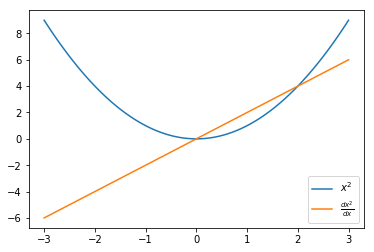

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.linspace(-3., 3., 100)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x**2

dy_dx = t.gradient(y, x)

plt.plot(x, y, label="$x^2$")
plt.plot(x, dy_dx, label=r"$\frac{dx^2}{dx}$")
plt.legend();

### Задание 3:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`

In [54]:
w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

def f(w):
    return tf.reduce_prod(tf.math.log(tf.math.log(w + 7))) 

with tf.GradientTape( ) as t:
    t.watch(w)
    y = f(w)
    
dy_dw = t.gradient(y, w)
dy_dw.numpy()

array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)

# 3. Переменные

Следущий важный объект в tensorflow это **переменная.** Она представляет из себя некоторый буфер в памяти, который содержит текущие тензоры. 

* Переменную можно вставить в любое место графа 
* Переменные можно использовать, чтобы описать какую-то трансформацию
* В процессе расчётов их можно изменять
* Обычно их исползуют для описания параметров модели

In [55]:
w = tf.Variable(initial_value=0.5)
w

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>

In [56]:
x = np.array([1,2,3], dtype=float)
x

array([1., 2., 3.])

In [57]:
x*w

<tf.Tensor: id=515, shape=(3,), dtype=float32, numpy=array([0.5, 1. , 1.5], dtype=float32)>

Более того, переменные хороши тем, что Tensorflow сразу же следит за ними при вычислении производных. Ему не надо указывать с помощью команды `watch`, за каким тензором нужно приглядывать. 

### Задание 4:

Реализуйте расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`. Отличие от предыдущей задачки такое: надо задать $w$ не как тензор, а как переменную. 

In [61]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])
# w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

def f(w):
    return tf.reduce_prod(tf.math.log(tf.math.log(w + 7))) 

with tf.GradientTape( ) as t:
    y = f(w)
    
dy_dw = t.gradient(y, w)
dy_dw.numpy()

array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)

------------------------------------------

# 4. Оптимизация

Итак, tf умеет искать производные, осталось научиться применять его для оптимизации. 

Попробуем решить глупую задачку по конвертации градусов по цельсию в градусы по фаренгейту. По данным будем пытаться восстановить формулу: 

$$ f = c \times 1.8 + 32 $$

In [9]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype='float32')
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype='float32')

for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

-40.0 degrees Celsius = -40.0 degrees Fahrenheit
-10.0 degrees Celsius = 14.0 degrees Fahrenheit
0.0 degrees Celsius = 32.0 degrees Fahrenheit
8.0 degrees Celsius = 46.0 degrees Fahrenheit
15.0 degrees Celsius = 59.0 degrees Fahrenheit
22.0 degrees Celsius = 72.0 degrees Fahrenheit
38.0 degrees Celsius = 100.0 degrees Fahrenheit


In [77]:
# параметры модели 
a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')

a.numpy(), b.numpy()

(array([0.07299773], dtype=float32), array([0.19492634], dtype=float32))

In [78]:
# Наша модель
def linear_regression(x):
    return a + b*x

# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

In [67]:
linear_regression(celsius).numpy()

array([-78.63289  , -19.166939 ,   0.6550454,  16.51263  ,  30.388018 ,
        44.263405 ,  75.97858  ], dtype=float32)

In [79]:
mean_square(linear_regression(celsius), fahrenheit).numpy()

2936.1223

In [69]:
# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [a, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [a, b]))

In [72]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([0.6550454], dtype=float32)>

In [73]:
model_train(celsius, fahrenheit)

In [74]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([0.71590316], dtype=float32)>

In [76]:
# Обучение
epochs = 2000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = linear_regression(celsius)
        loss_val = mean_square(y_pred, fahrenheit)
        print("step: %i, loss: %f, a: %f, b: %f" % (i, loss_val, a.numpy(), b.numpy()))

step: 0, loss: 933.447083, a: 0.775801, b: 2.059923
step: 100, loss: 635.530273, a: 6.228024, b: 2.015046
step: 200, loss: 432.702698, a: 10.726751, b: 1.977080
step: 300, loss: 294.613434, a: 14.438735, b: 1.945753
step: 400, loss: 200.599243, a: 17.501566, b: 1.919905
step: 500, loss: 136.592377, a: 20.028761, b: 1.898577
step: 600, loss: 93.015198, a: 22.113998, b: 1.880979
step: 700, loss: 63.346905, a: 23.834568, b: 1.866459
step: 800, loss: 43.148098, a: 25.254240, b: 1.854478
step: 900, loss: 29.396236, a: 26.425646, b: 1.844592
step: 1000, loss: 20.033676, a: 27.392197, b: 1.836435
step: 1100, loss: 13.659472, a: 28.189713, b: 1.829705
step: 1200, loss: 9.319791, a: 28.847757, b: 1.824151
step: 1300, loss: 6.365236, a: 29.390720, b: 1.819569
step: 1400, loss: 4.353703, a: 29.838734, b: 1.815788
step: 1500, loss: 2.984215, a: 30.208395, b: 1.812668
step: 1600, loss: 2.051836, a: 30.513412, b: 1.810094
step: 1700, loss: 1.417060, a: 30.765085, b: 1.807970
step: 1800, loss: 0.9848

Можно сделать то же самое, но с визуализацией. 

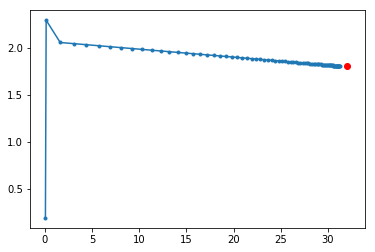

In [80]:
from IPython.display import clear_output

epochs = 2000 # число эпох 

ass = [a.numpy()[0]] # стартовые точки 
bss = [b.numpy()[0]] 

for i in range(epochs):
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    if i%25 == 0:
        # Пополняем запас точек 
        ass.append(a.numpy()[0])
        bss.append(b.numpy()[0])

        clear_output(True) # чтобы всё на одной картинке рисовалось, а не на милионе
        plt.plot(ass, bss, marker='.')
        plt.scatter(32, 1.8, c='red')
        plt.show()

### Задание 5:

Реализуйте для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

процедуру градиентного спуска. Каким получилось минимальное значение? 

In [86]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])
#v = tf.Variable(initial_value=[[5.,10], [1,2]])

def f(w): #, v):
    return tf.reduce_prod(tf.math.log(tf.math.log(w + 7))) # + v) 

optimizer = tf.optimizers.Adam()

def find_extremum():
    with tf.GradientTape( ) as t:
        y = f(w) #, v)

    dy_dw = t.gradient(y, [w]) #, v])
    
    # print(dy_dw, '\n')
    
    optimizer.apply_gradients(zip(dy_dw, [w]))#, v]))
    
for i in range(1000):
    find_extremum()
    if i % 100 == 0:
        print(w.numpy(), '\n')

[[4.999     9.999001 ]
 [0.9990001 1.9990001]] 

[[4.89909    9.899194  ]
 [0.89888996 1.8989629 ]] 

[[4.7994294 9.799888 ]
 [0.7984718 1.7988228]] 

[[4.7000394 9.70112  ]
 [0.6977404 1.6985866]] 

[[4.6009364  9.6029    ]
 [0.59669846 1.5982647 ]] 

[[4.5021334 9.505239 ]
 [0.495349  1.4978676]] 

[[4.403648   9.408151  ]
 [0.39369437 1.3974063 ]] 

[[4.3054943  9.31165   ]
 [0.29173735 1.2968924 ]] 

[[4.2076917  9.21575   ]
 [0.18948111 1.1963379 ]] 

[[4.1102576  9.120466  ]
 [0.08692703 1.0957549 ]] 



------------------------------------------

Можно попробовать поразвлекаться с разными методами оптимизации! 

* На вход модели при обучении мы сейчас подавали нумпаевские вектора. В будущем мы будем смотреть и на разные другие способы скармливать модели данные.

# 5. Нейронка на Tensorflow 

Пришло время страдать. Чтобы пострадать как следует, вы получаете задание --- построить свою первую нейросеть в tensorflow. __Спойлер:__ cильнее вего вы будете страдать от того, что размерности матриц не сходятся. Осторожнее с этим. 

Раньше все учили свою первую нейросеть на [наборе рукопистных цифр MNIST.](http://yann.lecun.com/exdb/mnist/) Теперь это не модно. Если где-то кто-то будет проводить у вас семинар с участием этого датасета, так и скажите ему: __это не модно!__  Хлопать дверью или нет --- на ваше усмотрение. 

На арене туториалов новый король: [Fashion MNIST.](https://www.tensorflow.org/tutorials/keras/classification) По ссылке лежит туториал с строительством нейросетки на этом наборе, но с участием Keras. Мы пока что обойдёмся без него.

In [87]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [88]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [89]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

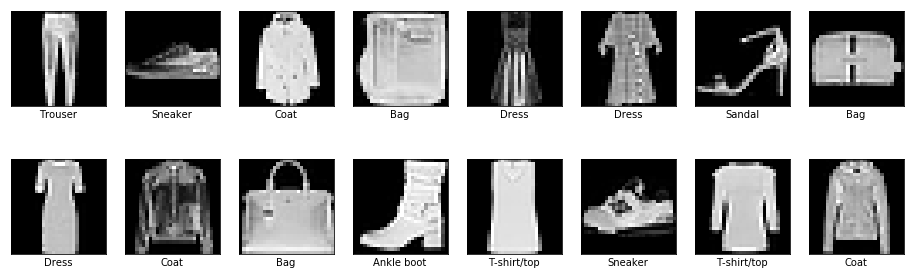

In [90]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

Каждая картинка это матрица из чисел. Если число большое - пиксель яркий. Если маленькое - тёмный. Яркость измеряется по шкале от $0$ до $255$.

In [91]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Картинка - матрица. 

In [92]:
X_train[0].shape

(28, 28)

Давайте отнормируем выборку. 

In [93]:
X_train = X_train/255
X_test = X_test/255

Будем прогнозировать тип картинки по её пикселям. Давайте растянем её в вектор из $28 \times 28$ фичей.

In [94]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

Поставим для данных тип, чтобы ничего не поломалось.

In [95]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

У нас в задаче фигурирует $10$ классов. Последним слоем в сетке будет Softmax. Не забудьте сделать OHE, когда будете описывать функцию потерь. 

In [96]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [97]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Задание 6

Для начала обучим однослойною модель. Задайте её архитектуру и напишите функцию для прогнозирования. 

In [98]:
num_classes = 10   # число классов
num_features = 784 # число фичей (28*28 пикселей)

# Задайте переменные W и b :) 
W = tf.Variable(initial_value=tf.random.normal([num_features, num_classes]))
b = tf.Variable(initial_value=tf.random.normal([num_classes]))

# прогнозы
def logistic_regression(X):
    h = X@W + b
    return tf.nn.softmax(h)

In [99]:
p_pred = logistic_regression(X_train[:3])
p_pred

<tf.Tensor: id=241966, shape=(3, 10), dtype=float32, numpy=
array([[9.9994278e-01, 1.0869054e-10, 1.8421243e-16, 1.6489083e-17,
        5.2752555e-05, 1.1523247e-14, 4.0558322e-19, 7.6711336e-07,
        3.6705810e-06, 2.8135339e-18],
       [9.9890888e-01, 3.1663916e-08, 1.8738228e-11, 7.0757578e-10,
        6.7854800e-18, 8.8804236e-10, 8.6079384e-18, 8.1577396e-05,
        1.0094973e-03, 9.5320866e-17],
       [7.0320904e-01, 2.9477340e-01, 3.0811336e-06, 3.2506487e-04,
        2.3796069e-07, 1.6624507e-03, 4.2772956e-07, 2.4230441e-05,
        1.2302322e-06, 8.0699613e-07]], dtype=float32)>

Отлично! Теперь давайте реализуем функцию потерь. Использовать будем logloss. Ещё не забыли как его искать? 

In [101]:
y_true = y_train[:3]

In [104]:
-tf.reduce_mean(tf.reduce_sum(tf.math.log(p_pred) * y_true, axis=1))

<tf.Tensor: id=241983, shape=(), dtype=float32, numpy=13.588428>

In [106]:
def logloss(p_pred, y_true):
    # Чтобы не возникло log(0) и бесконечностей
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    # а теперь считаем
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

Чтобы избежать проблем с бесконечностями, обычно logloss считают по-другому, с помощью функции tf.nn.softmax_cross_entropy_with_logits. Откуда берутся проблемы в виде бесконечностей в softmax либо посмотрите во второй лекции, либо в Николенко на страницах  133−135.

In [107]:
p_pred = logistic_regression(X_train)
logloss(p_pred, y_train)

<tf.Tensor: id=242007, shape=(), dtype=float32, numpy=14.877548>

На каждой итерации будем искать accuracy. Напишите функцию, чтобы его искать. 

In [110]:
def accuracy(p_pred, y_true):
    acc = tf.equal(tf.argmax(p_pred, axis=1),  tf.argmax(y_true, axis=1))
    acc = tf.cast(acc, tf.float32)
    return tf.reduce_mean(acc)

In [111]:
accuracy(p_pred, y_train)

<tf.Tensor: id=242023, shape=(), dtype=float32, numpy=0.10273334>

Задаём оптимизатор

In [113]:
learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)

Задаём один шаг обучения

In [115]:
def model_train(X, Y):

    with tf.GradientTape() as g:
        pred = logistic_regression(X)
        loss = logloss(pred, Y)
        
    gradients = g.gradient(loss, [W, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [116]:
W

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.21896091,  0.6674486 , -1.0207683 , ..., -0.5139865 ,
        -0.50323176, -1.920314  ],
       [-0.10769796,  0.92775273, -0.6813756 , ...,  0.16818467,
        -0.07372455,  2.5361629 ],
       [-0.6729403 , -0.57831335,  0.99330246, ..., -0.24817054,
         0.41199413, -0.3621268 ],
       ...,
       [ 0.9228071 , -0.11134952,  0.40418842, ..., -0.17027643,
        -0.17244586, -0.28952268],
       [ 0.5139579 ,  0.10908572, -0.5133649 , ..., -0.1861183 ,
         1.1336508 ,  0.04659789],
       [-0.274614  , -0.8238062 , -1.3189919 , ...,  1.1148119 ,
         0.26574764,  0.5124925 ]], dtype=float32)>

In [117]:
# Работает ли?
model_train(X_train, y_train)

In [118]:
W

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.21911119,  0.66744834, -1.0207481 , ..., -0.513988  ,
        -0.50319207, -1.920318  ],
       [-0.10751317,  0.9277439 , -0.68115056, ...,  0.16792971,
        -0.0735682 ,  2.536159  ],
       [-0.67239726, -0.578353  ,  0.99397665, ..., -0.24885862,
         0.4124653 , -0.36214763],
       ...,
       [ 0.9218091 , -0.11232834,  0.4051836 , ..., -0.17127292,
        -0.1714502 , -0.28860256],
       [ 0.5129652 ,  0.10813169, -0.51240045, ..., -0.18710881,
         1.1346381 ,  0.04750386],
       [-0.27554488, -0.8240762 , -1.318169  , ...,  1.1139567 ,
         0.26662076,  0.5131868 ]], dtype=float32)>

Остался только этап для обучения модели. Напишем функцию, которая будет генерировать из наших данных батчи. Одна эпоха - один проход модели по всем батчам. Один батч - совокупность наблюдений.  В этом может помочь [специальный класс для создания батчей, Dataset.](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [119]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

Напишем небольшую функцию для визуализации процедуры обучения. 

In [120]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

Обучаем модель! 

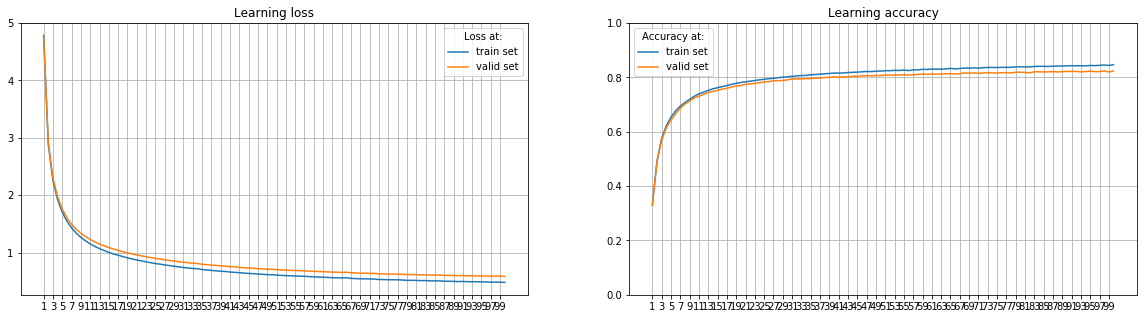

In [121]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        ### Ваш код для шага на текущем батче
        model_train(batch_x, batch_y)
        ########################
    
    # в конце эпохи считаем метрики
    p_train = logistic_regression(X_train)
    p_test = logistic_regression(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

Делать такие визуализации для больших нейронок и большого количества эпох не лучшая идея, но так как мы только учимся и хотим красивых картинок, то мы можем себе это позволить. __Отдельно обратите внимание,__ что TensorFlow очень чуствительна к размерностям. Например, чтобы работала функция `matmul`, нужно подать ей на вход обязательно матрицы. Даже если это матрица размера $1 \times 1$.

## Задание 7

Переделайте свою логистическую регрессию в двухслойную нейросетку. В качестве функции активации возьмите что угодно. Функцию, где будет реализована модель назовите `our_nn`.

In [124]:
num_classes = 10    # число классов
num_features = 784  # число фичей (28*28 пикселей)
hidden_neurons = 32 # число нейронов на скрытом слое

W1 = tf.Variable(initial_value=tf.random.normal([num_features, hidden_neurons]))
b1 = tf.Variable(initial_value=tf.random.normal([hidden_neurons]))

W2 = tf.Variable(initial_value=tf.random.normal([hidden_neurons, num_classes]))
b2 = tf.Variable(initial_value=tf.random.normal([num_classes]))

def our_nn(X):
    h1 = X@W1 + b1
    o1 = tf.nn.sigmoid(h1)
    h2 = o1@W2 + b2
    return tf.nn.softmax(h2)

def logloss(p_pred, y_true):
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

def accuracy(p_pred, y_true):
    acc = tf.equal(tf.argmax(p_pred, axis=1),  tf.argmax(y_true, axis=1))
    acc = tf.cast(acc, tf.float32)
    return tf.reduce_mean(acc)

learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)

def model_train(X, Y):

    with tf.GradientTape() as g:
        pred = our_nn(X)
        loss = logloss(pred, Y)
        
    gradients = g.gradient(loss, [W1, W2, b1, b2])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W1, W2, b1, b2]))

Обучаем модель!

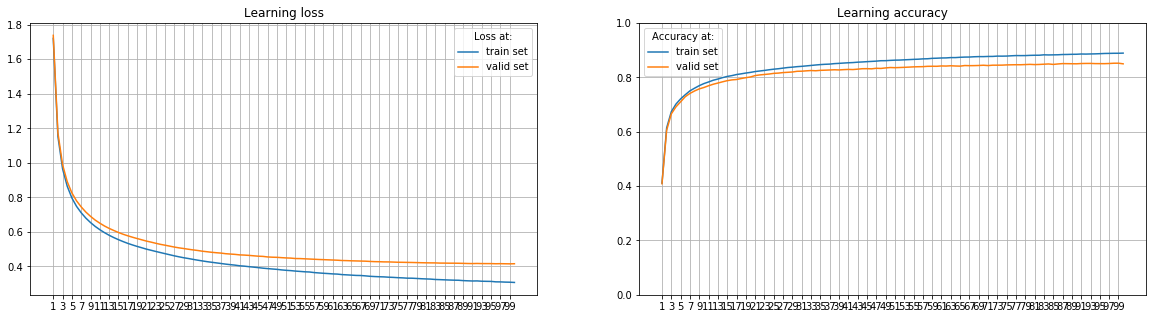

In [125]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(5000).batch(512)

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        model_train(batch_x, batch_y)
    
    p_train = our_nn(X_train)
    p_test = our_nn(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

# Вместо итога.

__Но... Но... Но... Намного проще собрать это в Keras! Зачем нам страдать?__

Дело в том, что Keras лишь надстройка над tensorflow. По факту все слои, написанные для Keras - это замаскированный tensorflow. Более того, даже сетку, написанную на Keras можно обучать таким вот незатейливым циклом, как у нас. Иногда так намного проще проверять свои идеи. 

* Например, в прошлый раз мы с вами пытались мень скорость обучения сетки с помощью колбэков прямо в процессе обучения. Это было довольно неприятно и код был неочевидным. Если описывать процедуру обучения в виде цикла, работать становится проще.  В Tensorflow проще делать довольно много разных вещей, а также проще реализовывать и проверять какие-то свои идеи. 
* В том числе на Tensorflow можно писать новые слои для Keras и встраивать их в свои сетки. Этим мы тоже с вами позанимаемся.

In [147]:
from tensorflow.keras import Model
keras, L = tf.keras, tf.keras.layers

In [175]:
class MyEncoder(Model):
    def __init__(self, dense_units):
        super(MyEncoder, self).__init__()
        self.dense_units = dense_units
        self.encoder_layers = [ ]
        self.last_layer = L.Dense(10, activation=tf.nn.softmax)
        self.__create_layers__()
        
    def __create_layers__(self):
        k = self.dense_units
        while k >= 16:
            self.encoder_layers.append(L.Dense(k, activation=tf.nn.relu))
            k = k // 2
                
    def call(self, x):
        
        h = self.encoder_layers[0](x)
        h = self.encoder_layers[1](h)
        h1 = h
        h = tf.concat([x, h], axis=1)
        
        skip_cnt = 1
        for layer in self.encoder_layers[3:]:
            
            skip_cnt +=1 
            h = layer(h)
            
            if skip_cnt == 2:
                skip_cnt = 0
                h1 = h
                h = tf.concat([h1, h], axis=1)
            
        p = self.last_layer(h)
        return p

In [176]:
def logloss(p_pred, y_true):
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

def accuracy(p_pred, y_true):
    acc = tf.equal(tf.argmax(p_pred, axis=1),  tf.argmax(y_true, axis=1))
    acc = tf.cast(acc, tf.float32)
    return tf.reduce_mean(acc)

learning_rate = 1e-3
optimizer = tf.optimizers.Adam(learning_rate)

encoder = MyEncoder(dense_units=512)

def encoder_train(X, Y):

    with tf.GradientTape() as g:
        pred = encoder(X)
        loss = logloss(pred, Y)
        
    gradients = g.gradient(loss, encoder.trainable_variables)
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables))

In [177]:
encoder(X_train)[:2]

<tf.Tensor: id=2739703, shape=(2, 10), dtype=float32, numpy=
array([[0.06250913, 0.03223265, 0.04330295, 0.1108484 , 0.05149741,
        0.04953394, 0.26566446, 0.18709795, 0.12715472, 0.07015829],
       [0.07933847, 0.04695517, 0.04501472, 0.12106805, 0.0922019 ,
        0.06125145, 0.16343829, 0.18866892, 0.12505926, 0.07700377]],
      dtype=float32)>

In [178]:
for l in encoder.trainable_variables:
    print(l.shape)

(784, 512)
(512,)
(512, 256)
(256,)
(1040, 64)
(64,)
(128, 32)
(32,)
(32, 16)
(16,)
(32, 10)
(10,)


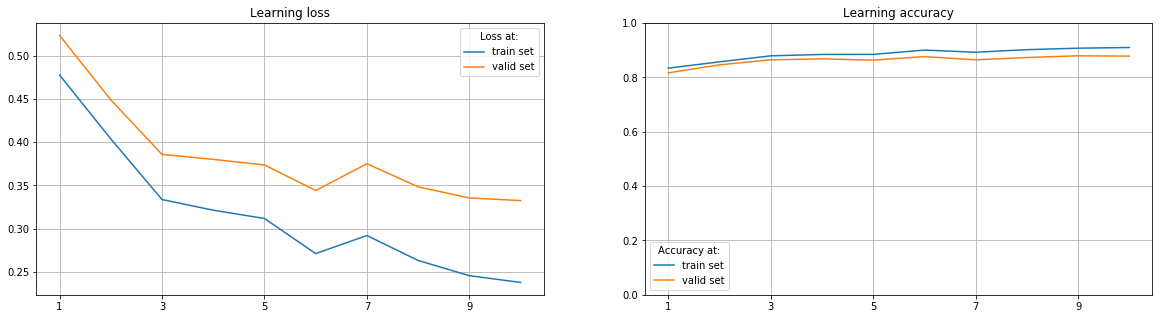

In [179]:
epochs = 10            # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(5000).batch(512)

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        encoder_train(batch_x, batch_y)
    
    p_train = encoder(X_train)
    p_test = encoder(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

# N+1. Как Tensorflow работал раньше 

Больше такой код не надо писать никогда и нигде. Если видите его в туториалах в интернете, сразу закрывайте их. Эти туториалы устарели. Можете попробовать подуть на них (сдуть слой пыли), а дальше попробовать самостоятельно переписать старый код на новый. Это неплохое упражнение :) 

In [1]:
import tensorflow.compat.v1 as tf  # подгружаем первую версию библиотеки 
tf.disable_v2_behavior()           # отключаем функционал второй 
                                   # теперь код, написанный на версии tf 1.x должен работать 
tf.__version__

W0618 21:38:29.390499 140736695505856 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


'2.0.0'

Раньше сначала надо было задать структуру вычислений с помощью тензоров. 

In [2]:
# что происходило в первой версии 
a = tf.constant([1, 2])
b = tf.constant([3, 4])

print(a + b)

Tensor("add:0", shape=(2,), dtype=int32)


Результат на лету было увидеть нельзя. 

In [3]:
c = a + b
c

<tf.Tensor 'add_1:0' shape=(2,) dtype=int32>

Если хотелось результата, надо было запускать вычислительную сессию, которая прогоняла все данные через граф.

In [4]:
# открываем вычислительную сессию 
with tf.Session() as sess:
    print(sess.run(c))

[4 6]


In [5]:
# либо можно было открыть глобальную сессию 
sess = tf.InteractiveSession()
c.eval()

array([4, 6], dtype=int32)

Процедура обучения модели выглядела раньше иначе. Кроме переменных в обучении участие принимал ещё один объект, `placeholder`. 

* __placeholder__ — место в графе, которое может принимать входные параметры в граф извне. В эти места мы будем вставлять наши данные

In [10]:
epochs = 10

# плейсхолдеры для данных 
# "Я обещаю вставить сюда x и y позже"
x = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)

# параметры модели 
a = tf.Variable(tf.zeros([1]), name='bias')
b = tf.Variable(tf.zeros([1]), name='k')

# модель 
y_hat = b*x + a

# функция потерь и метод оптимизации
loss = tf.sqrt(tf.reduce_sum((y - y_hat)**2))
opt = tf.train.AdamOptimizer(learning_rate = 0.1)

# из-за того, что не было динамических вычислений, 
# было проще с градиентами
step = opt.minimize(loss)

# Но зато было сложнее с процедурой обучения, надо было запускать ... сессии
# открываем вычислительную сессию 
with tf.Session() as sess:
    
    # инициализировали все переменные 
    tf.global_variables_initializer().run() 
    
    for i in range(epochs):
        
        # Дорогая сессия, вычисли мне результат функции потерь, пожалуйста! Вот тебе конкретные x и y! 
        cur_loss = sess.run(loss, feed_dict={x:celsius, y:fahrenheit})
        print('Текущие потери:', cur_loss)
        
        # шаг оптимизации 
        sess.run(step, feed_dict={x:celsius, y:fahrenheit})
        
    print('\nКоэффициенты:', a.eval()[0], b.eval()[0])
    print('Прогнозы:', sess.run(y_hat, feed_dict={x:[-40,0,38]}))

Текущие потери: 153.62617
Текущие потери: 148.2056
Текущие потери: 142.8606
Текущие потери: 137.60123
Текущие потери: 132.43892
Текущие потери: 127.38669
Текущие потери: 122.45928
Текущие потери: 117.67331
Текущие потери: 113.047386
Текущие потери: 108.60223

Коэффициенты: 1.0066519 0.9923882
Прогнозы: [-38.688873    1.0066519  38.717403 ]


## Почиташки

* [Эффективный tensorflow 2.0](https://www.tensorflow.org/guide/effective_tf2)
* [Простые примеры кода на tensorflow 2.0](https://github.com/aymericdamien/TensorFlow-Examples/tree/master/tensorflow_v2)
* [Очень-очень милая презентация про fashion mnist](https://github.com/fbchow/fashion-mnist-tensorflow/blob/master/ml-fashion-mnist-presentation.pdf)


__Немного старья:__

* [Введение в старую версию Tensorflow на Хабре](https://habrahabr.ru/company/ods/blog/324898/)
* [Введение в старый Tensorflow от ШАД,](https://nbviewer.jupyter.org/github/yandexdataschool/Practical_DL/blob/fall18/week02_autodiff/seminar_tensorflow.ipynb) моя тетрадка частично основана на этой тетрадке, хоть сходство на первый взгляд и не заметно. 
* [Неплохая подборка разных тетрадок](https://github.com/Hvass-Labs/TensorFlow-Tutorials) на старом tensorflow